In [1]:
# In this notebook, we will evaluate the results of the synthetic dataset training runs


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import json

from scipy.spatial.distance import directed_hausdorff

from src.interface_representation.interface_types import InterfaceType
from eval_utils import *

base_output_dir = pathlib.Path('./../../output/lassen')
files = list(base_output_dir.glob('interfacial_ae_v25_*'))

print(len(files))

24


In [3]:
print(files)

[PosixPath('../../output/lassen/interfacial_ae_v25_run_15_datadirspheres_mu_200_TANH_EPSILON025_seed0'), PosixPath('../../output/lassen/interfacial_ae_v25_run_21_datadirspheres_mu_250_TANH_EPSILON00625_seed0'), PosixPath('../../output/lassen/interfacial_ae_v25_run_08_datadirspheres_mu_200_SIGNED_DISTANCE_EXACT_seed0'), PosixPath('../../output/lassen/interfacial_ae_v25_run_18_datadirspheres_mu_250_TANH_EPSILON00078125_seed0'), PosixPath('../../output/lassen/interfacial_ae_v25_run_06_datadirspheres_mu_100_TANH_EPSILON0125_seed0'), PosixPath('../../output/lassen/interfacial_ae_v25_run_05_datadirspheres_mu_100_TANH_EPSILON00625_seed0'), PosixPath('../../output/lassen/interfacial_ae_v25_run_01_datadirspheres_mu_100_HEAVISIDE_seed0'), PosixPath('../../output/lassen/interfacial_ae_v25_run_07_datadirspheres_mu_100_TANH_EPSILON025_seed0'), PosixPath('../../output/lassen/interfacial_ae_v25_run_00_datadirspheres_mu_100_SIGNED_DISTANCE_EXACT_seed0'), PosixPath('../../output/lassen/interfacial_ae_v

In [4]:
def read_loss_curve_from_file(outdir):
    loss_path = outdir / 'loss_history.json'
    with open(loss_path) as f:
        loss_curve = json.load(f)
    return loss_curve

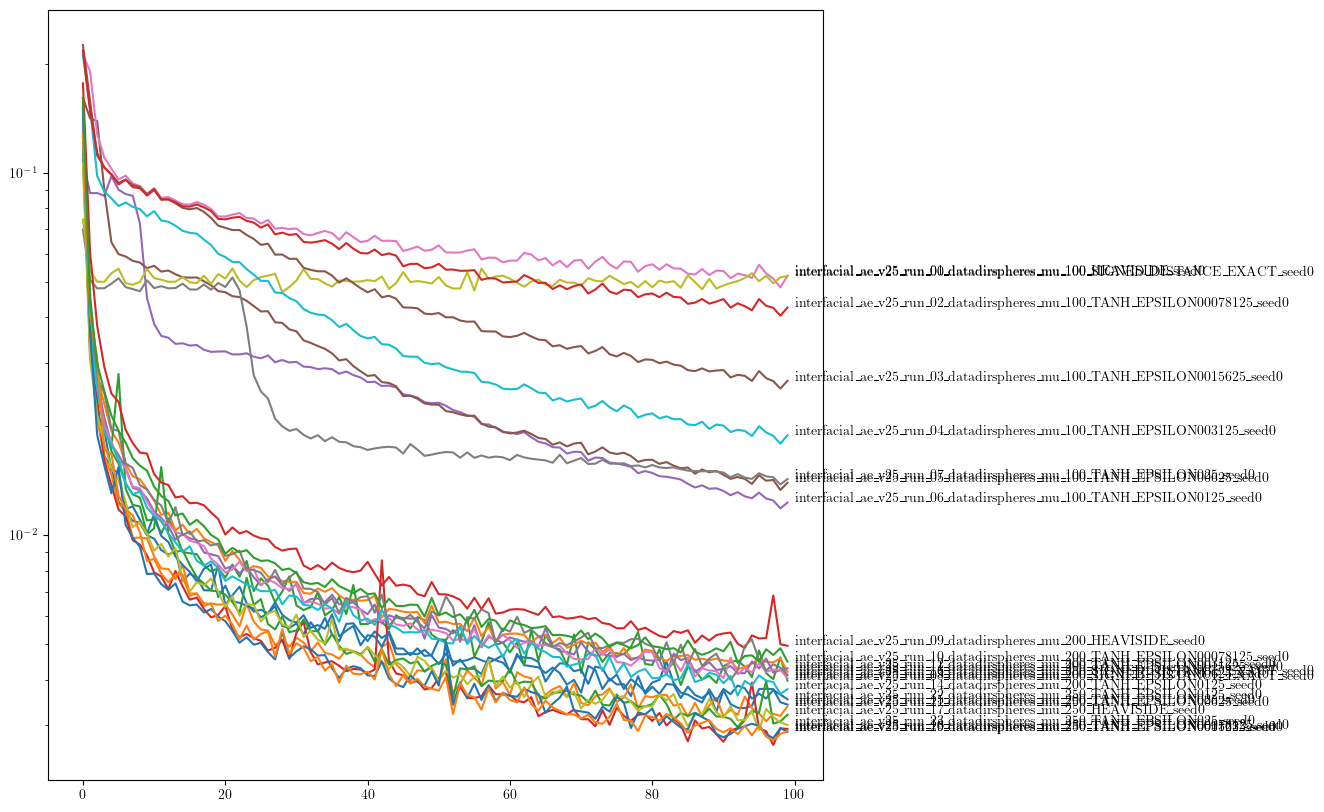

In [5]:
# Compare all the loss curves on one axis


name_to_loss = {}

for f in files:
    name_to_loss[f] = read_loss_curve_from_file(f)

fig, ax = plt.subplots(figsize=(10, 10))
loss_component = 'Total'
for f, loss in name_to_loss.items():
    ax.plot(loss[loss_component], label=f.name)

    # Annotate name on the end of the curve
    ax.text(len(loss[loss_component]), loss[loss_component][-1], f.name)
#ax.legend()
ax.set_yscale('log')
plt.show()



In [6]:
# Functions to group the data by interface type and epsilon

def extract_interface_type(outdir):
    
    final_part = '_'.join(outdir.stem.split('_')[8:-1])

    str_to_type = {
        'TANH_EPSILON00078125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0015625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON003125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON00625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON025': InterfaceType.TANH_EPSILON,
        'HEAVISIDE': InterfaceType.HEAVISIDE,
        'SIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
        'SIGNED_DISTANCE_APPROXIMATE': InterfaceType.SIGNED_DISTANCE_APPROXIMATE,
    }

    return str_to_type[final_part]

def extract_epsilon(outdir):
    final_part = '_'.join(outdir.stem.split('_')[8:-1])
    
    str_to_epsilon = {
        'TANH_EPSILON00078125': 0.0078125,
        'TANH_EPSILON0015625': 0.015625,
        'TANH_EPSILON003125': 0.03125,
        'TANH_EPSILON00625': 0.0625,
        'TANH_EPSILON0125': 0.125,
        'TANH_EPSILON025': 0.25,
        'HEAVISIDE': None,
        'SIGNED_DISTANCE_EXACT': None,
        'SIGNED_DISTANCE_APPROXIMATE': None,
    }
    
    return str_to_epsilon[final_part]


def extract_mu(outdir):
    mu_part = outdir.stem.split('_')[7]
    
    if mu_part == '100':
        return 1.00
    elif mu_part == '200':
        return 2.00
    elif mu_part == '250':
        return 2.50
    else:
        raise ValueError
    

def get_modal_path(outdir):
    return outdir / 'model-100.pt'


def get_dataset_path(mu, interfacetype, epsilon):
    if interfacetype == InterfaceType.TANH_EPSILON:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_{mu:.2f}/TANH_EPSILON{epsilon}')
    elif interfacetype == InterfaceType.HEAVISIDE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_{mu:.2f}/HEAVISIDE')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_{mu:.2f}/SIGNED_DISTANCE_EXACT')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_{mu:.2f}/SIGNED_DISTANCE_APPROXIMATE')
    else:
        raise ValueError('Unknown interface type')
    
    
    

In [7]:
outdir_to_params = {}

for outdir in files:
   interfacetype = extract_interface_type(outdir)
   mu = extract_mu(outdir)
   epsilon = extract_epsilon(outdir)
   model_path = get_modal_path(outdir)
   dataset_path = get_dataset_path(mu, interfacetype, epsilon)
   
   assert model_path.exists()
   assert dataset_path.exists(), f'{dataset_path} does not exist'
   
   params = {
       'mu': mu,
       'interface_type': interfacetype,
       'epsilon': epsilon,
       'model_path': model_path,
       'dataset_path': dataset_path
   }
   
   outdir_to_params[outdir] = params
    
print(outdir_to_params)

{PosixPath('../../output/lassen/interfacial_ae_v25_run_15_datadirspheres_mu_200_TANH_EPSILON025_seed0'): {'mu': 2.0, 'interface_type': <InterfaceType.TANH_EPSILON: 1>, 'epsilon': 0.25, 'model_path': PosixPath('../../output/lassen/interfacial_ae_v25_run_15_datadirspheres_mu_200_TANH_EPSILON025_seed0/model-100.pt'), 'dataset_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_2.00/TANH_EPSILON0.25')}, PosixPath('../../output/lassen/interfacial_ae_v25_run_21_datadirspheres_mu_250_TANH_EPSILON00625_seed0'): {'mu': 2.5, 'interface_type': <InterfaceType.TANH_EPSILON: 1>, 'epsilon': 0.0625, 'model_path': PosixPath('../../output/lassen/interfacial_ae_v25_run_21_datadirspheres_mu_250_TANH_EPSILON00625_seed0/model-100.pt'), 'dataset_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_2.50/TANH_EPSILON0.0625')}, PosixPath('../../output/l

In [8]:
# Run inference for all

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    
    dataset = load_dataset(params['dataset_path'])
    model = load_model(params['model_path'])
    gts, preds = run_inference(dataset, model, N=500)
    
    # Save outdir, preds, params, gt to disk, ready to be reloaded at evaluation time!
    
    np.savez_compressed(outfile, gts=gts, preds=preds, **params)

../../output/lassen/interfacial_ae_v25_run_15_datadirspheres_mu_200_TANH_EPSILON025_seed0
Loading model to device: mps


/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/notebooks/ai_fluids_2025/eval_utils.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.l

Running inference on device: mps


  0%|          | 0/500 [00:00<?, ?it/s]/Users/murray/miniconda3/envs/mfe/lib/python3.12/site-packages/torch/nn/functional.py:4538: UserWarning: The operator 'aten::upsample_nearest3d.vec' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_nearest3d(input, output_size, scale_factors)
100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_21_datadirspheres_mu_250_TANH_EPSILON00625_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_08_datadirspheres_mu_200_SIGNED_DISTANCE_EXACT_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_18_datadirspheres_mu_250_TANH_EPSILON00078125_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_06_datadirspheres_mu_100_TANH_EPSILON0125_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [08:10<00:00,  1.02it/s]


../../output/lassen/interfacial_ae_v25_run_05_datadirspheres_mu_100_TANH_EPSILON00625_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [08:11<00:00,  1.02it/s]


../../output/lassen/interfacial_ae_v25_run_01_datadirspheres_mu_100_HEAVISIDE_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [08:12<00:00,  1.01it/s]


../../output/lassen/interfacial_ae_v25_run_07_datadirspheres_mu_100_TANH_EPSILON025_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


../../output/lassen/interfacial_ae_v25_run_00_datadirspheres_mu_100_SIGNED_DISTANCE_EXACT_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_04_datadirspheres_mu_100_TANH_EPSILON003125_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_22_datadirspheres_mu_250_TANH_EPSILON0125_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_11_datadirspheres_mu_200_TANH_EPSILON0015625_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_17_datadirspheres_mu_250_HEAVISIDE_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_09_datadirspheres_mu_200_HEAVISIDE_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_12_datadirspheres_mu_200_TANH_EPSILON003125_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_03_datadirspheres_mu_100_TANH_EPSILON0015625_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_13_datadirspheres_mu_200_TANH_EPSILON00625_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_16_datadirspheres_mu_250_SIGNED_DISTANCE_EXACT_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_23_datadirspheres_mu_250_TANH_EPSILON025_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_14_datadirspheres_mu_200_TANH_EPSILON0125_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_20_datadirspheres_mu_250_TANH_EPSILON003125_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_19_datadirspheres_mu_250_TANH_EPSILON0015625_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_10_datadirspheres_mu_200_TANH_EPSILON00078125_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


../../output/lassen/interfacial_ae_v25_run_02_datadirspheres_mu_100_TANH_EPSILON00078125_seed0
Loading model to device: mps
Running inference on device: mps


100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


In [9]:
# Go over each file, and load predictions, compute metrics from each volume

outdir_to_metrics = {}

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    data = np.load(outfile)
    
    gts = data['gts']
    preds = data['preds']
    
    # Convert to sharp interface
    interfacetype = params['interface_type']
    
    # Compute metrics
    # 2. Dice coefficient
    
    dices = []
    
    for gt, pred in zip(gts, preds):
        gt = get_phi_sharp(gt, interfacetype)
        pred = get_phi_sharp(pred, interfacetype)
        
        dice = dice_coefficient(gt, pred)
        dices.append(dice)
        
    print(np.mean(dices))
        
    outdir_to_metrics[outdir] = {
        'Dice': dices,
        'gts': gts,
        'preds': preds
    }
    

../../output/lassen/interfacial_ae_v25_run_15_datadirspheres_mu_200_TANH_EPSILON025_seed0
0.9692782087620818
../../output/lassen/interfacial_ae_v25_run_21_datadirspheres_mu_250_TANH_EPSILON00625_seed0
0.9850915308938494
../../output/lassen/interfacial_ae_v25_run_08_datadirspheres_mu_200_SIGNED_DISTANCE_EXACT_seed0
0.9693594550463838
../../output/lassen/interfacial_ae_v25_run_18_datadirspheres_mu_250_TANH_EPSILON00078125_seed0
0.9866498948720696
../../output/lassen/interfacial_ae_v25_run_06_datadirspheres_mu_100_TANH_EPSILON0125_seed0
0.6300121104898487
../../output/lassen/interfacial_ae_v25_run_05_datadirspheres_mu_100_TANH_EPSILON00625_seed0
0.647059805760745
../../output/lassen/interfacial_ae_v25_run_01_datadirspheres_mu_100_HEAVISIDE_seed0
0.7529232152499687
../../output/lassen/interfacial_ae_v25_run_07_datadirspheres_mu_100_TANH_EPSILON025_seed0
0.6352925854027588
../../output/lassen/interfacial_ae_v25_run_00_datadirspheres_mu_100_SIGNED_DISTANCE_EXACT_seed0
0.0
../../output/lassen

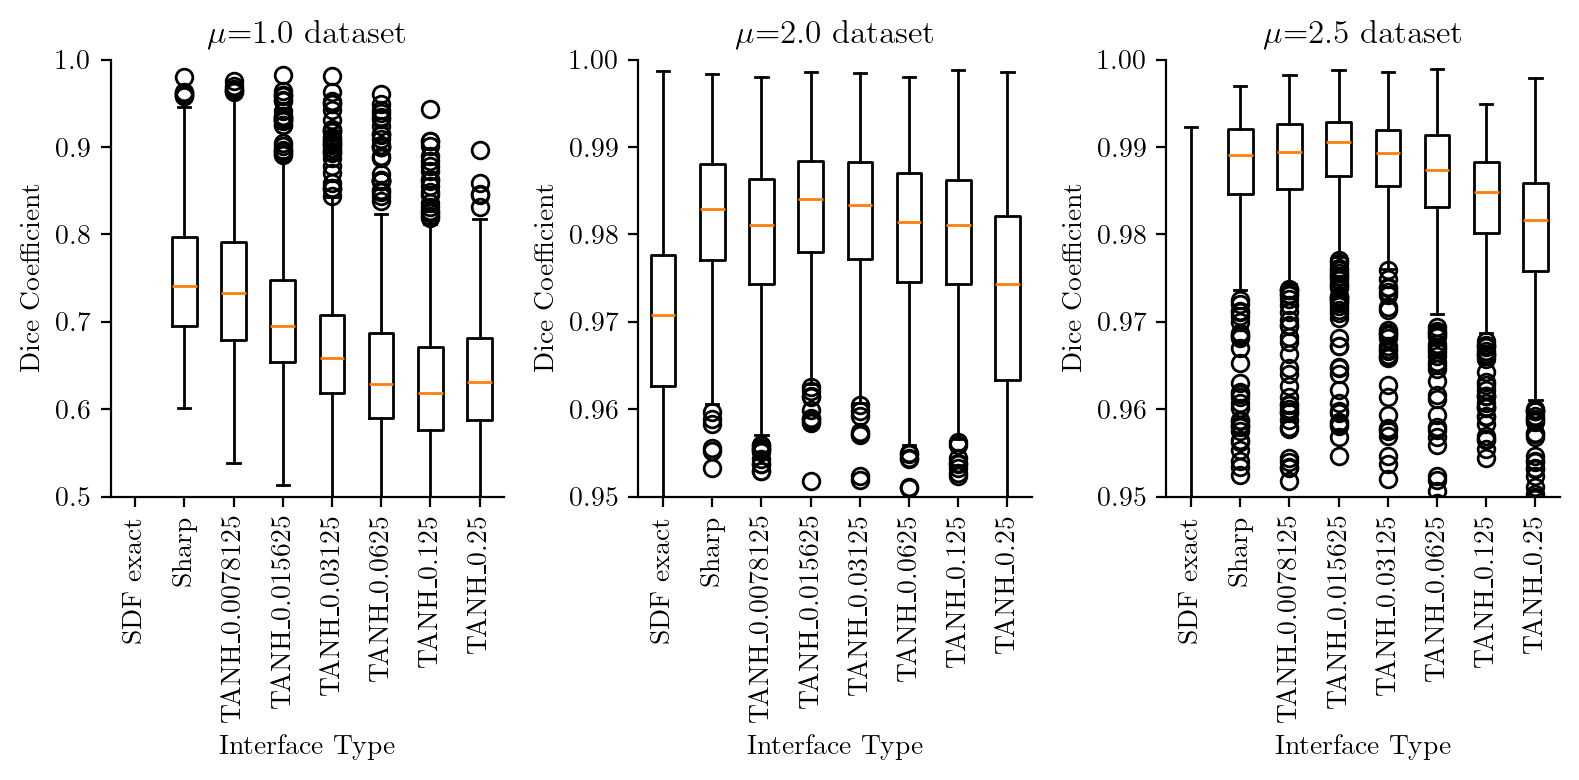

In [10]:
import matplotlib.pyplot as plt
from fractions import Fraction

def float_to_fraction(float_num):
    fraction = Fraction(float_num).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"

mus = set(p['mu'] for p in outdir_to_params.values())

# Group data by mu value
mu_to_data = {mu: {} for mu in mus}

for outdir, params in outdir_to_params.items():
    mu = params['mu']
    interface_type = params['interface_type']
    epsilon = params['epsilon']
    dice_scores = outdir_to_metrics[outdir]['Dice']
    
    if interface_type == InterfaceType.TANH_EPSILON:
        label = f'TANH_{epsilon}'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
        label = 'SDF exact'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        label = 'SDF approx'
    else:
        label = 'Sharp'
    
    if label not in mu_to_data[mu]:
        mu_to_data[mu][label] = []
    
    mu_to_data[mu][label].extend(dice_scores)
    
# Sort labels by interface type
for mu in mu_to_data:
    mu_to_data[mu] = dict(sorted(mu_to_data[mu].items(), key=lambda item: item[0]))

# Sort labels by epsilon value
for mu in mu_to_data:
    mu_to_data[mu] = dict(sorted(mu_to_data[mu].items(), key=lambda item: float(item[0].split('_')[-1]) if 'TANH' in item[0] else 0))
    
# Create box plots
fig, axs = plt.subplots(1, len(mus), figsize=(8, 4), dpi=200)

for i, mu in enumerate(mus):
    data = [mu_to_data[mu][label] for label in mu_to_data[mu]]
    labels = list(mu_to_data[mu].keys())
    axs[i].boxplot(data, tick_labels=labels)
    axs[i].set_title(f'$\\mu$={mu} dataset')
    axs[i].set_xlabel('Interface Type')
    axs[i].set_ylabel('Dice Coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].tick_params(axis='x', rotation=90)
    
axs[0].set_ylim(0.5, 1)
axs[1].set_ylim(0.95, 1)
axs[2].set_ylim(0.95, 1)

plt.tight_layout()
plt.show()

In [24]:
# Compute all HD metrics and then plot them as above

def hausdorff_distance(gt_patch, pred_patch, level: float = 0.5):
    """Returns the Hausdorff distance of the foreground region, obtained by thresholding the images at level

    Note:
        The distance is in units of voxels, assumes isotropic voxels

    Args:
        gt_patch: Ground truth patch
        pred_patch: Predicted patch
        level: Threshold level
        max_num_points: Maximum number of points to use in the distance calculation (for speed purposes)
    """
    gt_patch = gt_patch > level
    pred_patch = pred_patch > level

    gt_indices = np.argwhere(gt_patch)
    pred_indices = np.argwhere(pred_patch)
    
    if len(gt_indices) == 0 or len(pred_indices) == 0:
        return np.nan

    h_1 = directed_hausdorff(gt_indices, pred_indices)[0]
    h_2 = directed_hausdorff(pred_indices, gt_indices)[0]
    return max(h_1, h_2)


outdir_to_hausdorff = {}

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    data = np.load(outfile)

    gts = data['gts']
    preds = data['preds']

    # Convert to sharp interface
    interfacetype = params['interface_type']

    hds = []

    for gt, pred in tqdm(list(zip(gts, preds))[:50]):
        gt = get_phi_sharp(gt, interfacetype)
        pred = get_phi_sharp(pred, interfacetype)
        
        hd = hausdorff_distance(gt, pred, level=0.5)
        hds.append(hd)

    print(np.mean(hds))

    outdir_to_metrics[outdir] = {
        'Hausdorff': hds,
        'gts': gts,
        'preds': preds
    }



../../output/lassen/interfacial_ae_v25_run_15_datadirspheres_mu_200_TANH_EPSILON025_seed0


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


2.7645697036945376
../../output/lassen/interfacial_ae_v25_run_21_datadirspheres_mu_250_TANH_EPSILON00625_seed0


100%|██████████| 50/50 [01:23<00:00,  1.66s/it]


1.7671720499929355
../../output/lassen/interfacial_ae_v25_run_08_datadirspheres_mu_200_SIGNED_DISTANCE_EXACT_seed0


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


3.4482529703549467
../../output/lassen/interfacial_ae_v25_run_18_datadirspheres_mu_250_TANH_EPSILON00078125_seed0


100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


1.804831141030814
../../output/lassen/interfacial_ae_v25_run_06_datadirspheres_mu_100_TANH_EPSILON0125_seed0


100%|██████████| 50/50 [00:01<00:00, 31.82it/s]


10.194334505979539
../../output/lassen/interfacial_ae_v25_run_05_datadirspheres_mu_100_TANH_EPSILON00625_seed0


100%|██████████| 50/50 [00:01<00:00, 33.09it/s]


9.832438720656182
../../output/lassen/interfacial_ae_v25_run_01_datadirspheres_mu_100_HEAVISIDE_seed0


100%|██████████| 50/50 [00:01<00:00, 39.88it/s]


17.414685147685017
../../output/lassen/interfacial_ae_v25_run_07_datadirspheres_mu_100_TANH_EPSILON025_seed0


100%|██████████| 50/50 [00:01<00:00, 28.67it/s]


15.177648121525053
../../output/lassen/interfacial_ae_v25_run_00_datadirspheres_mu_100_SIGNED_DISTANCE_EXACT_seed0


100%|██████████| 50/50 [00:00<00:00, 442.08it/s]


nan
../../output/lassen/interfacial_ae_v25_run_04_datadirspheres_mu_100_TANH_EPSILON003125_seed0


100%|██████████| 50/50 [00:01<00:00, 36.56it/s]


10.287421501966042
../../output/lassen/interfacial_ae_v25_run_22_datadirspheres_mu_250_TANH_EPSILON0125_seed0


100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


1.8538644371315156
../../output/lassen/interfacial_ae_v25_run_11_datadirspheres_mu_200_TANH_EPSILON0015625_seed0


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


2.7874418291450076
../../output/lassen/interfacial_ae_v25_run_17_datadirspheres_mu_250_HEAVISIDE_seed0


100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


1.8206013724298744
../../output/lassen/interfacial_ae_v25_run_09_datadirspheres_mu_200_HEAVISIDE_seed0


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


3.1038260605425494
../../output/lassen/interfacial_ae_v25_run_12_datadirspheres_mu_200_TANH_EPSILON003125_seed0


100%|██████████| 50/50 [00:24<00:00,  2.00it/s]


2.4255126064992956
../../output/lassen/interfacial_ae_v25_run_03_datadirspheres_mu_100_TANH_EPSILON0015625_seed0


100%|██████████| 50/50 [00:01<00:00, 35.35it/s]


13.184252609562527
../../output/lassen/interfacial_ae_v25_run_13_datadirspheres_mu_200_TANH_EPSILON00625_seed0


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


2.3141846489285074
../../output/lassen/interfacial_ae_v25_run_16_datadirspheres_mu_250_SIGNED_DISTANCE_EXACT_seed0


100%|██████████| 50/50 [01:22<00:00,  1.66s/it]


nan
../../output/lassen/interfacial_ae_v25_run_23_datadirspheres_mu_250_TANH_EPSILON025_seed0


100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


1.4584135682047359
../../output/lassen/interfacial_ae_v25_run_14_datadirspheres_mu_200_TANH_EPSILON0125_seed0


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


2.7752157148528056
../../output/lassen/interfacial_ae_v25_run_20_datadirspheres_mu_250_TANH_EPSILON003125_seed0


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


1.768864793848675
../../output/lassen/interfacial_ae_v25_run_19_datadirspheres_mu_250_TANH_EPSILON0015625_seed0


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


1.8206877276967952
../../output/lassen/interfacial_ae_v25_run_10_datadirspheres_mu_200_TANH_EPSILON00078125_seed0


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


2.9436520177294363
../../output/lassen/interfacial_ae_v25_run_02_datadirspheres_mu_100_TANH_EPSILON00078125_seed0


100%|██████████| 50/50 [00:01<00:00, 40.34it/s]

15.49883921043995


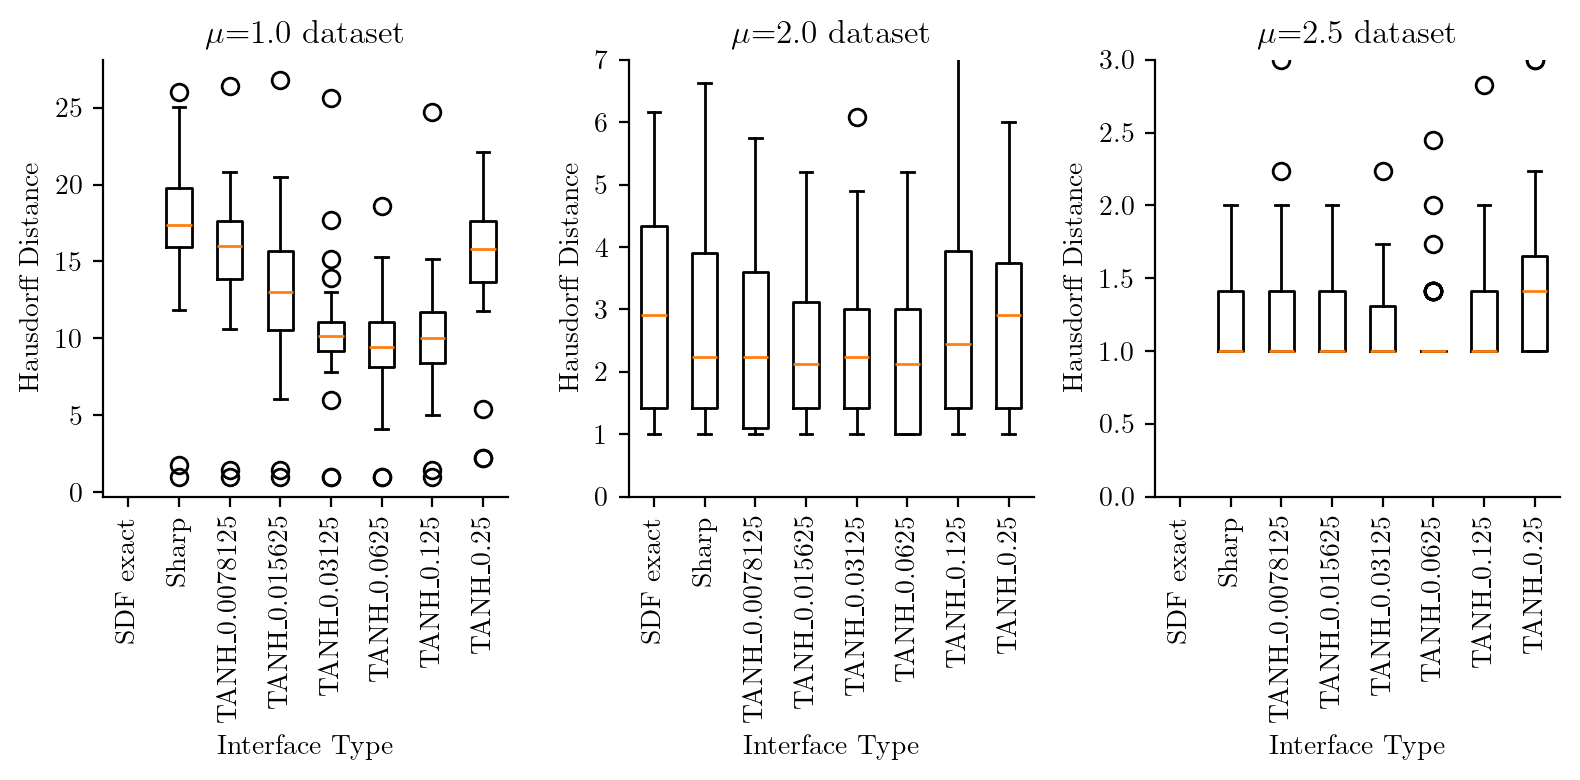

In [28]:
import matplotlib.pyplot as plt

# Group data by mu value
mu_to_hd_data = {mu: {} for mu in mus}

for outdir, params in outdir_to_params.items():
    mu = params['mu']
    interface_type = params['interface_type']
    epsilon = params['epsilon']
    hd_scores = outdir_to_metrics[outdir]['Hausdorff']

    if interface_type == InterfaceType.TANH_EPSILON:
        label = f'TANH_{epsilon}'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
        label = 'SDF exact'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        label = 'SDF approx'
    else:
        label = 'Sharp'

    if label not in mu_to_hd_data[mu]:
        mu_to_hd_data[mu][label] = []

    mu_to_hd_data[mu][label].extend(hd_scores)

# Sort labels by interface type
for mu in mu_to_hd_data:
    mu_to_hd_data[mu] = dict(sorted(mu_to_hd_data[mu].items(), key=lambda item: item[0]))

# Sort labels by epsilon value
for mu in mu_to_hd_data:
    mu_to_hd_data[mu] = dict(sorted(mu_to_hd_data[mu].items(), key=lambda item: float(item[0].split('_')[-1]) if 'TANH' in item[0] else 0))

# Create box plots
fig, axs = plt.subplots(1, len(mus), figsize=(8, 4), dpi=200)

for i, mu in enumerate(mus):
    data = [mu_to_hd_data[mu][label] for label in mu_to_hd_data[mu]]
    labels = list(mu_to_hd_data[mu].keys())
    axs[i].boxplot(data, tick_labels=labels)
    axs[i].set_title(f'$\\mu$={mu} dataset')
    axs[i].set_xlabel('Interface Type')
    axs[i].set_ylabel('Hausdorff Distance')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].tick_params(axis='x', rotation=90)
    
axs[1].set_ylim(0, 7)
axs[2].set_ylim(0, 3)

plt.tight_layout()
plt.show()

In [11]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label

# Function to compute droplet PDF
def compute_droplet_pdf(arr):
    labeled_arr, num_labels = label(arr)
    sizes = np.bincount(labeled_arr.ravel())
    return sizes[1:]

# Group PDF data by interface type, epsilon, and mu value

interface_to_epsilon_to_mu_data = {}

for interface in InterfaceType:
    try:
        epsilons = sorted(set(params['epsilon'] for params in outdir_to_params.values() if params['interface_type'] == interface))
    except:
        epsilons = [None]
    interface_to_epsilon_to_mu_data[interface] = {epsilon: {mu: {'gt': [], 'pred': []} for mu in mus} for epsilon in epsilons}

print(interface_to_epsilon_to_mu_data)

for outdir, params in outdir_to_params.items():
    mu = params['mu']
    epsilon = params['epsilon']
    interface_type = params['interface_type']
    gts = outdir_to_metrics[outdir]['gts']
    preds = outdir_to_metrics[outdir]['preds']
    
    for gt, pred in zip(gts, preds):
        gt, pred = get_phi_sharp_pred_and_gt(pred, gt, interface_type)
        interface_to_epsilon_to_mu_data[interface_type][epsilon][mu]['gt'].extend(compute_droplet_pdf(gt))
        interface_to_epsilon_to_mu_data[interface_type][epsilon][mu]['pred'].extend(compute_droplet_pdf(pred))


{<InterfaceType.TANH_EPSILON: 1>: {0.0078125: {1.0: {'gt': [], 'pred': []}, 2.0: {'gt': [], 'pred': []}, 2.5: {'gt': [], 'pred': []}}, 0.015625: {1.0: {'gt': [], 'pred': []}, 2.0: {'gt': [], 'pred': []}, 2.5: {'gt': [], 'pred': []}}, 0.03125: {1.0: {'gt': [], 'pred': []}, 2.0: {'gt': [], 'pred': []}, 2.5: {'gt': [], 'pred': []}}, 0.0625: {1.0: {'gt': [], 'pred': []}, 2.0: {'gt': [], 'pred': []}, 2.5: {'gt': [], 'pred': []}}, 0.125: {1.0: {'gt': [], 'pred': []}, 2.0: {'gt': [], 'pred': []}, 2.5: {'gt': [], 'pred': []}}, 0.25: {1.0: {'gt': [], 'pred': []}, 2.0: {'gt': [], 'pred': []}, 2.5: {'gt': [], 'pred': []}}}, <InterfaceType.SIGNED_DISTANCE_EXACT: 2>: {None: {1.0: {'gt': [], 'pred': []}, 2.0: {'gt': [], 'pred': []}, 2.5: {'gt': [], 'pred': []}}}, <InterfaceType.SIGNED_DISTANCE_APPROXIMATE: 3>: {}, <InterfaceType.HEAVISIDE: 4>: {None: {1.0: {'gt': [], 'pred': []}, 2.0: {'gt': [], 'pred': []}, 2.5: {'gt': [], 'pred': []}}}}


In [12]:
def get_label(interfacetype, epsilon) -> str:
    if interfacetype == InterfaceType.TANH_EPSILON:
        return f'TANH_{epsilon}'
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return 'SDF exact'
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return 'SDF approx'
    elif interfacetype == InterfaceType.HEAVISIDE:
        return 'Sharp'
    else:
        raise ValueError('Unknown interface type')
    
# Now change interface_to_epsilon_to_mu_data to label_to_mu_data

label_to_mu_data = {}

for interface, epsilon_to_mu_data in interface_to_epsilon_to_mu_data.items():
    for epsilon, mu_data in epsilon_to_mu_data.items():
        label = get_label(interface, epsilon)
        print(label)
        
        if label not in label_to_mu_data:
            label_to_mu_data[label] = {mu: {'gt': [], 'pred': []} for mu in mus}
        
        for mu in mus:
            label_to_mu_data[label][mu]['gt'].extend(mu_data[mu]['gt'])
            label_to_mu_data[label][mu]['pred'].extend(mu_data[mu]['pred'])

TANH_0.0078125
TANH_0.015625
TANH_0.03125
TANH_0.0625
TANH_0.125
TANH_0.25
SDF exact
Sharp


TANH_0.0078125 1.0 13845 48429
TANH_0.0078125 2.0 3405 3517
TANH_0.0078125 2.5 970 977
TANH_0.015625 1.0 36576 48422
TANH_0.015625 2.0 3465 3516
TANH_0.015625 2.5 972 977
TANH_0.03125 1.0 48673 48401
TANH_0.03125 2.0 3400 3516
TANH_0.03125 2.5 968 977
TANH_0.0625 1.0 44281 48363
TANH_0.0625 2.0 3452 3516
TANH_0.0625 2.5 974 977
TANH_0.125 1.0 28532 48303
TANH_0.125 2.0 3462 3514
TANH_0.125 2.5 979 977
TANH_0.25 1.0 12523 48147
TANH_0.25 2.0 3395 3514
TANH_0.25 2.5 962 977
SDF exact 1.0 0 48437
SDF exact 2.0 3546 3517
SDF exact 2.5 1015 977
Sharp 1.0 10607 48437
Sharp 2.0 3454 3517
Sharp 2.5 974 977


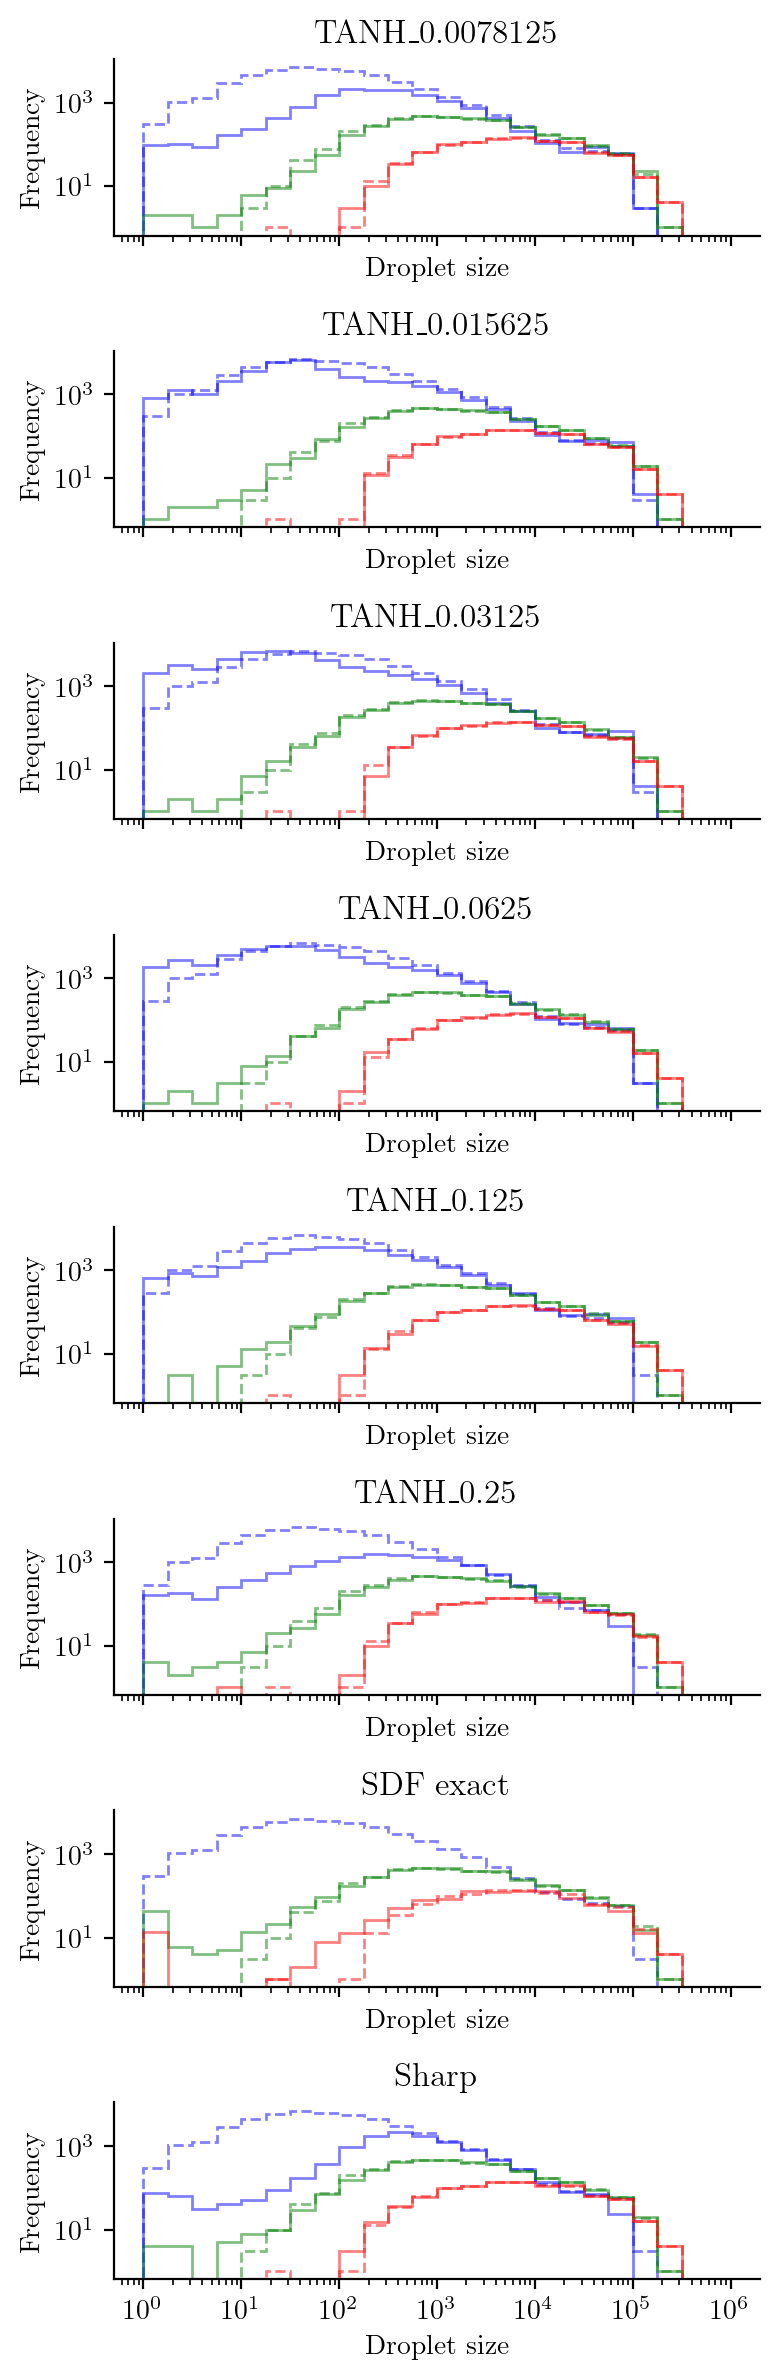

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the droplet PDFs for each label
fig, axs = plt.subplots(len(label_to_mu_data), 1, figsize=(4, 12), dpi=200, sharex=True, sharey=True)

colors = ['b', 'g', 'r']
num_bins = 25

for i, (label, mu_data) in enumerate(label_to_mu_data.items()):
    for j, mu in enumerate(mus):
        data = mu_data[mu]
        print(label, mu, len(data['gt']), len(data['pred']))
        min_bin = 1
        max_bin = 1e6
        bins = np.logspace(np.log10(min_bin), np.log10(max_bin), num_bins)

        axs[i].hist(data['gt'], bins=bins, alpha=0.5, label=f'GT mu={mu}', histtype='step', color=colors[j])
        axs[i].hist(data['pred'], bins=bins, alpha=0.5, label=f'Pred mu={mu}', histtype='step', linestyle='dashed', color=colors[j])
        axs[i].set_title(f'{label}')
        axs[i].set_xlabel('Droplet size')
        axs[i].set_ylabel('Frequency')
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

In [14]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from scipy import ndimage

def compute_surface_area_density(phi):
    # Assume phi represents a volume fraction
    dx = 1 / phi.shape[-1]
    grad_phi = np.gradient(phi, dx)  # List of (64, 64, 64) arrays
    abs_grad_phi = np.sqrt(np.sum([g**2 for g in grad_phi], axis=0))
    surface_area = np.sum(abs_grad_phi)
    volume = np.sum(phi)
    return surface_area / volume

def compute_num_components(phi):
    labeled_arr, num_labels = ndimage.label(phi)
    return num_labels

def compute_volume_fraction(phi):
    return np.sum(phi) / phi.size

plot_label_to_mu_to_sigmas = {label: {mu: [] for mu in mus} for label in label_to_mu_data}
plot_label_to_mu_to_dices = {label: {mu: [] for mu in mus} for label in label_to_mu_data}
plot_label_to_mu_to_num_components = {label: {mu: [] for mu in mus} for label in label_to_mu_data}
plot_label_to_mu_to_volume_fraction = {label: {mu: [] for mu in mus} for label in label_to_mu_data}

for outdir, params in outdir_to_params.items():
    gts = outdir_to_metrics[outdir]['gts']
    interfacetype = params['interface_type']
    plot_label = get_label(interfacetype, params['epsilon'])
    mu = params['mu']
    dice_scores = outdir_to_metrics[outdir]['Dice']
    
    assert len(gts) == len(dice_scores)

    for gt in gts:
        phi = get_phi_sharp(gt, interfacetype)
        sigma = compute_surface_area_density(phi)
        vol_frac = compute_volume_fraction(phi)
        num_components = compute_num_components(phi)
        plot_label_to_mu_to_sigmas[plot_label][mu].append(sigma)
        plot_label_to_mu_to_num_components[plot_label][mu].append(num_components)
        plot_label_to_mu_to_volume_fraction[plot_label][mu].append(vol_frac)
        
    for dice in dice_scores:
        plot_label_to_mu_to_dices[plot_label][mu].append(dice)
        

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_7541/3864704490.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis', len(unique_mu_values) + 1)
/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_7541/3864704490.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i].scatter(sigma, dice_scores, alpha=0.25, label=f'$\\mu$={mu}', c=mu_to_color[mu])


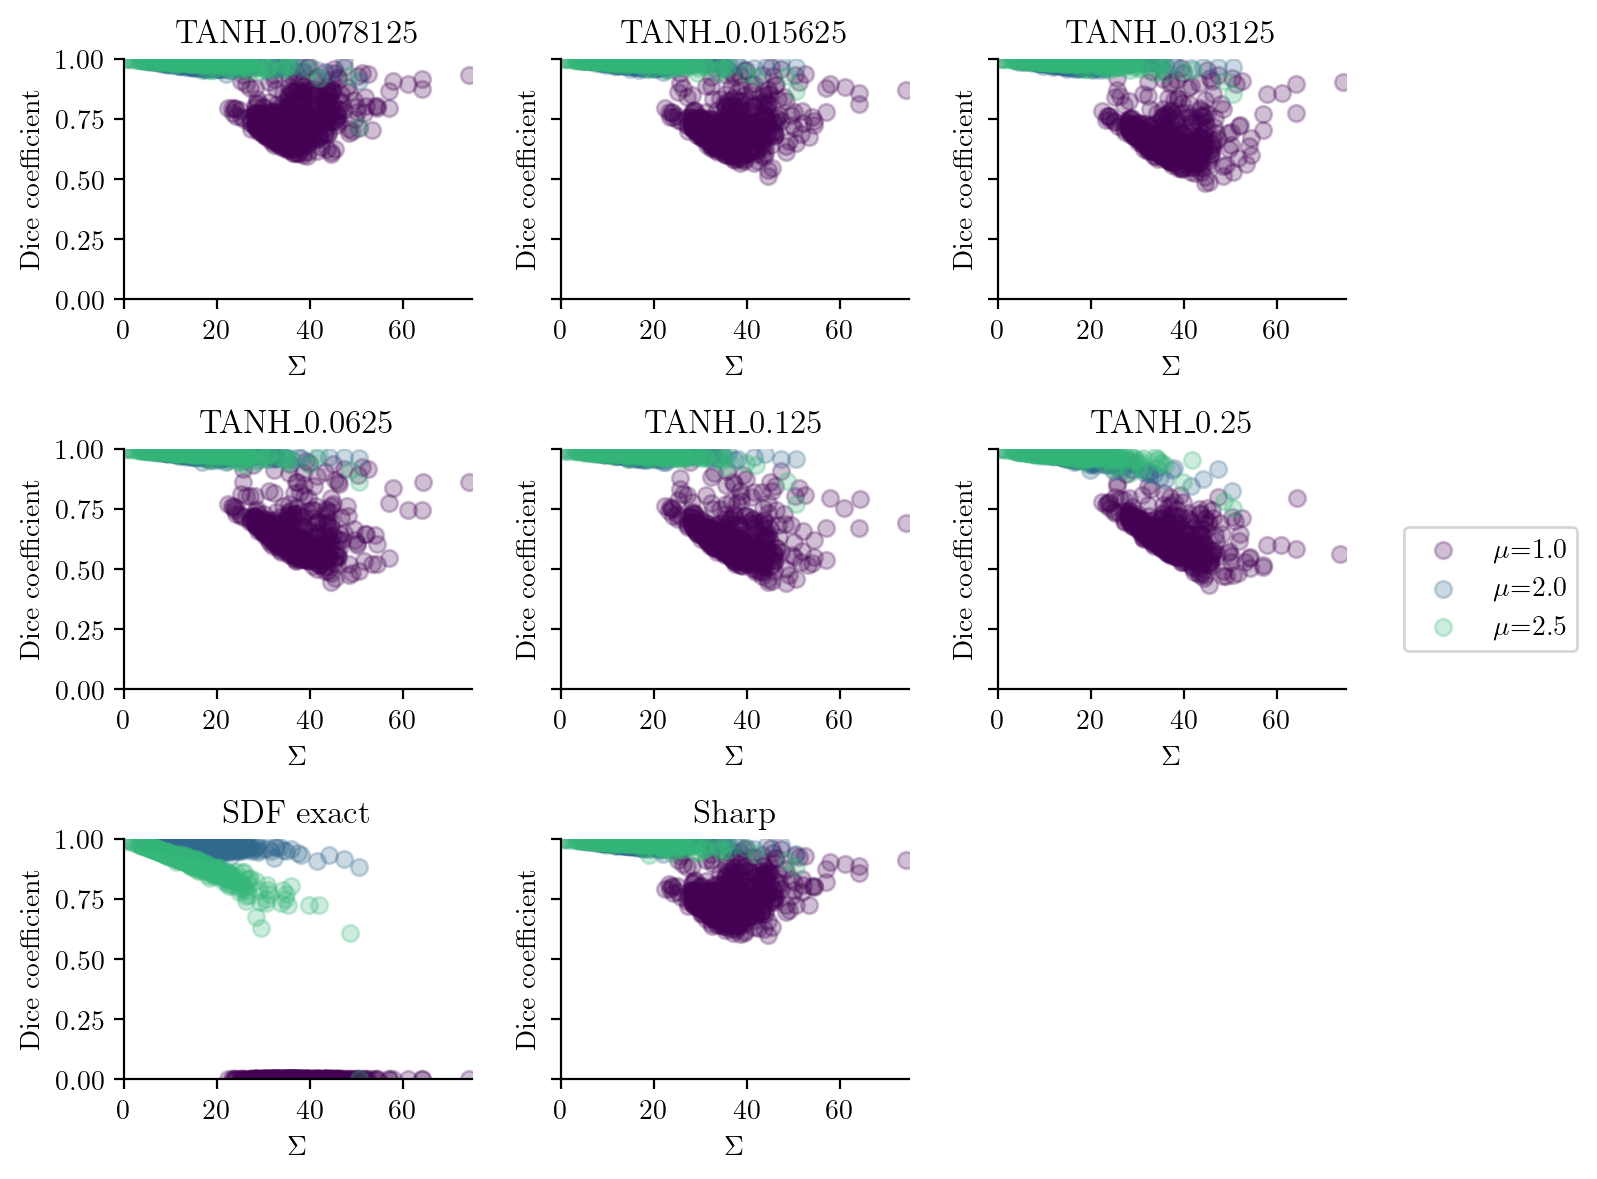

In [21]:
import matplotlib.cm as cm

# Scatter plot of sigma vs dice coefficient
fig, axs = plt.subplots(3, 3, figsize=(7, 6), sharey=True, dpi=200)
axs = axs.flatten()  # Flatten the 3x3 array to make indexing easier

unique_mu_values = sorted({mu for mu_to_sigmas in plot_label_to_mu_to_sigmas.values() for mu in mu_to_sigmas})
colormap = cm.get_cmap('viridis', len(unique_mu_values) + 1)
mu_to_color = {mu: colormap(i) for i, mu in enumerate(unique_mu_values)}

for i, label in enumerate(plot_label_to_mu_to_sigmas):
    mu_to_sigmas = plot_label_to_mu_to_sigmas[label]
    mu_to_dices = plot_label_to_mu_to_dices[label]

    for mu, sigma in mu_to_sigmas.items():
        dice_scores = mu_to_dices[mu]
        axs[i].scatter(sigma, dice_scores, alpha=0.25, label=f'$\\mu$={mu}', c=mu_to_color[mu])

    axs[i].set_title(label)
    axs[i].set_xlabel('$\\Sigma$')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_xlim(0, 75)
    axs[i].set_ylim(0.0, 1)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add a custom legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_7541/2677187435.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i].scatter(num_components, dice_scores, alpha=0.25, label=f'$\\mu$={mu}', c=mu_to_color[mu])


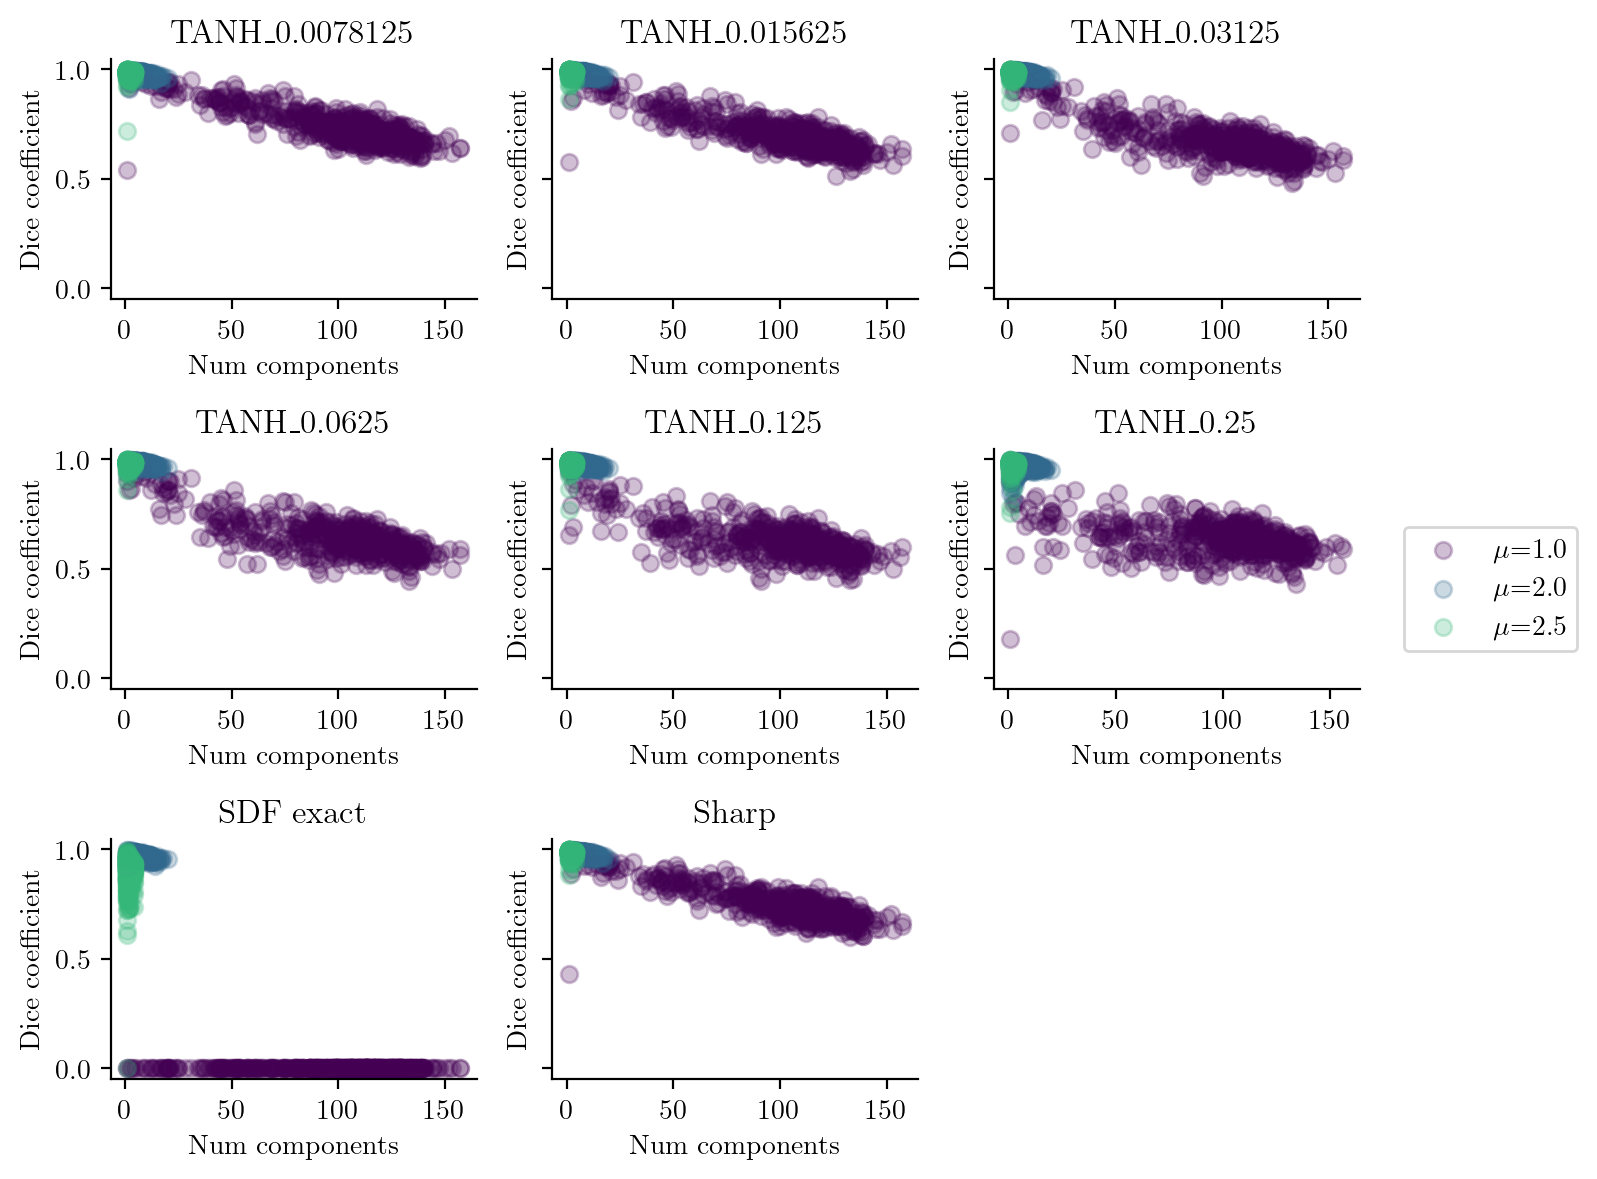

In [16]:
# Scatter plot of num_components vs dice coefficient

fig, axs = plt.subplots(3, 3, figsize=(7, 6), sharey=True, dpi=200)
axs = axs.flatten()  # Flatten the 3x3 array to make indexing easier

for i, label in enumerate(plot_label_to_mu_to_num_components):
    mu_to_num_components = plot_label_to_mu_to_num_components[label]
    mu_to_dices = plot_label_to_mu_to_dices[label]

    for mu, num_components in mu_to_num_components.items():
        dice_scores = mu_to_dices[mu]
        axs[i].scatter(num_components, dice_scores, alpha=0.25, label=f'$\\mu$={mu}', c=mu_to_color[mu])

    axs[i].set_title(label)
    axs[i].set_xlabel('Num components')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    
# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])
    
# Add a custom legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

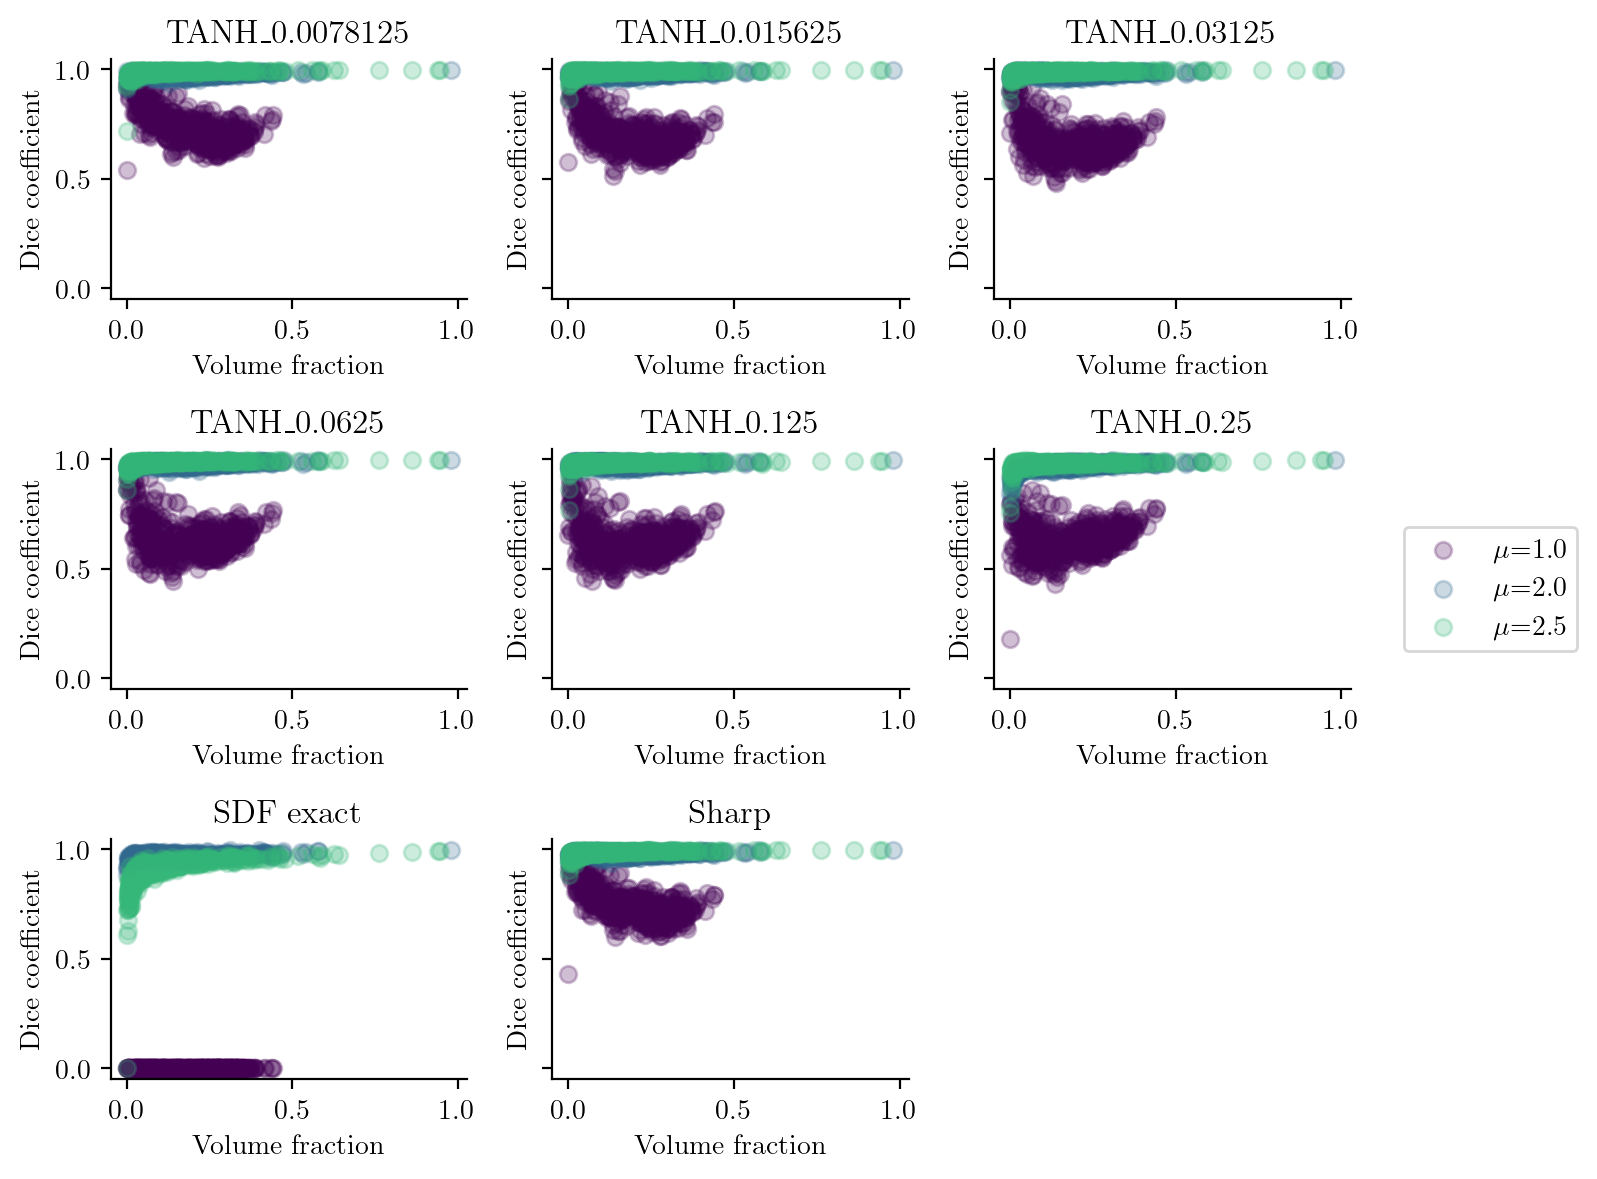

In [17]:
# Scatter plot of volume fraction vs dice coefficient

fig, axs = plt.subplots(3, 3, figsize=(7, 6), sharey=True, dpi=200)
axs = axs.flatten()  # Flatten the 3x3 array to make indexing easier

for i, label in enumerate(plot_label_to_mu_to_volume_fraction):
    mu_to_volfrac = plot_label_to_mu_to_volume_fraction[label]
    mu_to_dices = plot_label_to_mu_to_dices[label]

    for mu, num_components in mu_to_volfrac.items():
        dice_scores = mu_to_dices[mu]
        axs[i].scatter(num_components, dice_scores, alpha=0.25, label=f'$\\mu$={mu}', color=mu_to_color[mu])

    axs[i].set_title(label)
    axs[i].set_xlabel('Volume fraction')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add a custom legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


Dice: 0.9828247653898365, Vol frac: 0.032566070556640625, Sigma: 27.027103424072266, Num components: 7


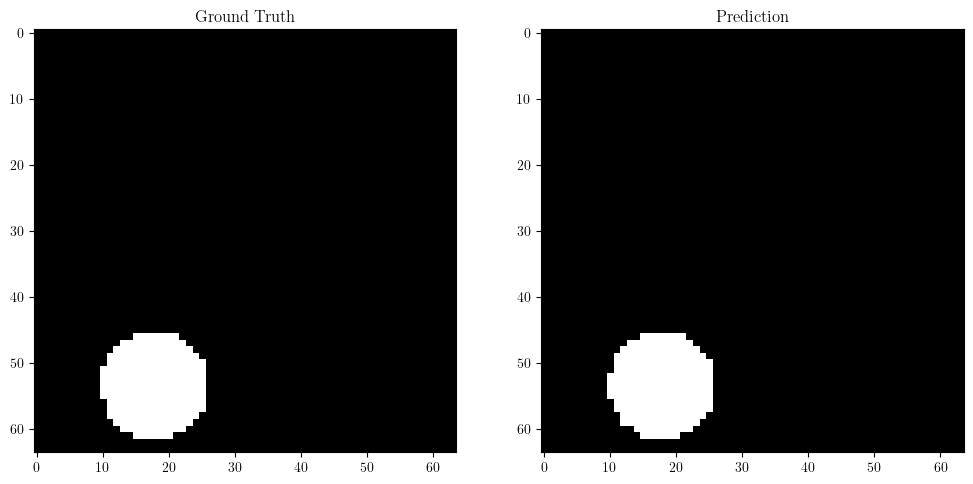

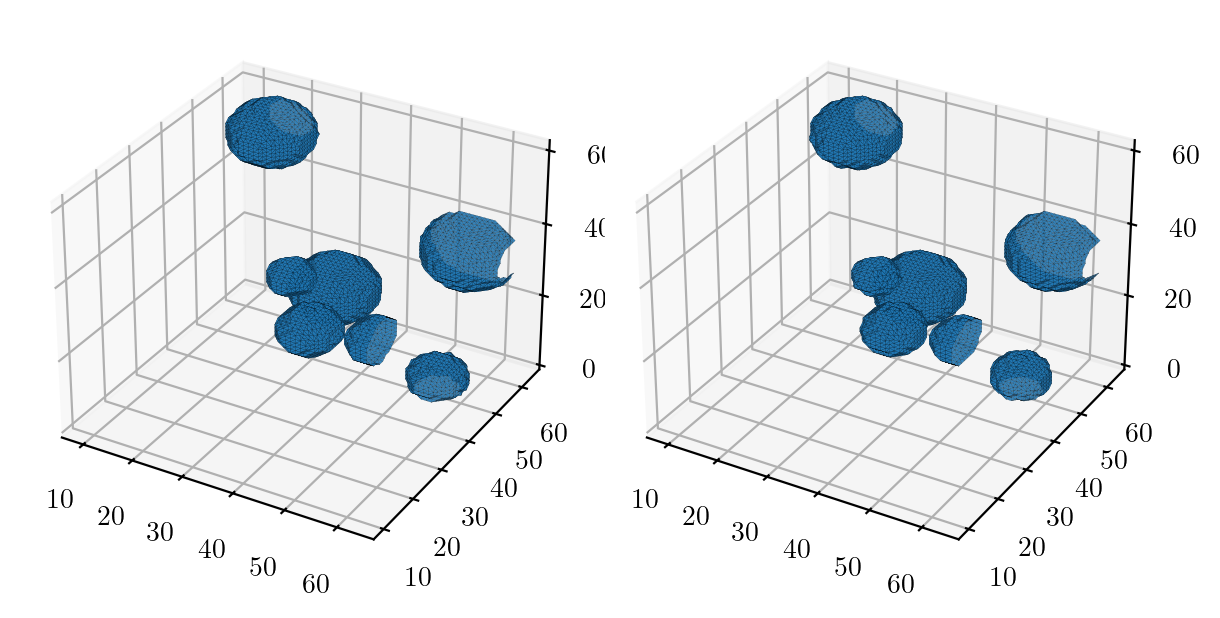

In [18]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import skimage

def visualize_gt_pred(interface_type, mu, epsilon, sample_index):
    for outdir, params in outdir_to_params.items():
        if params['interface_type'] == interface_type and params['mu'] == mu and params['epsilon'] == epsilon:
            
            data = np.load(outdir / 'inference.npz')
            gts = data['gts']
            preds = data['preds']
            
            gt = gts[sample_index]
            pred = preds[sample_index]
            
            gt = get_phi_sharp(gt, interface_type)
            pred = get_phi_sharp(pred, interface_type)
            
            dice = dice_coefficient(gt, pred)
            vol_frac = compute_volume_fraction(gt)
            sigma = compute_surface_area_density(gt)
            num_components = compute_num_components(gt)
            
            print(f'Dice: {dice}, Vol frac: {vol_frac}, Sigma: {sigma}, Num components: {num_components}')
            
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(gt[gt.shape[0] // 2], cmap='gray')
            axs[0].set_title('Ground Truth')
            axs[1].imshow(pred[pred.shape[0] // 2], cmap='gray')
            axs[1].set_title('Prediction')
            plt.show()



            fig = plt.figure(figsize=(6, 6), dpi=200)
            ax = fig.add_subplot(121, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                gt, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces])
            mesh.set_edgecolor("k")
            mesh.set_linewidth(0.05)
            mesh.set_alpha(0.9)
            ax.add_collection3d(mesh)
            
            ax = fig.add_subplot(122, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                pred, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces])
            mesh.set_edgecolor("k")
            mesh.set_linewidth(0.05)
            mesh.set_alpha(0.9)
            ax.add_collection3d(mesh)

            plt.tight_layout()
            break

# Example usage
visualize_gt_pred(InterfaceType.TANH_EPSILON, 2.0, 1/32, 0)

In [19]:
def find_samples_in_volume_fraction_window(interface_type, mu, epsilon, volume_fraction_min, volume_fraction_max):
    sample_indices = []
    
    for outdir, params in outdir_to_params.items():
        if params['interface_type'] == interface_type and params['mu'] == mu and params['epsilon'] == epsilon:
            data = np.load(outdir / 'inference.npz')
            gts = data['gts']
            preds = data['preds']
            
            for i, gt, pred in zip(range(len(gts)), gts, preds):
                gt = get_phi_sharp(gt, interface_type)
                pred = get_phi_sharp(pred, interface_type)
                dice = dice_coefficient(gt, pred)
                vol_frac = compute_volume_fraction(gt)
                if volume_fraction_min <= vol_frac <= volume_fraction_max:
                    sample_indices.append((i, dice))
            
    return sample_indices

# Example usage
sample_indices = find_samples_in_volume_fraction_window(InterfaceType.TANH_EPSILON, 1.0, 1/32, 0.25, 0.26)
print(sample_indices)

[(25, 0.5719654670496815), (50, 0.6381366739179356), (61, 0.7553053466969143), (64, 0.6248433162358985), (71, 0.7161066223665332), (87, 0.690068417241736), (142, 0.6120467783446968), (157, 0.5777736822705493), (219, 0.704052463426938), (254, 0.6128055914075885), (275, 0.6810522487574251), (320, 0.6329974693763487), (328, 0.5752344643537933), (355, 0.5808765568343055), (392, 0.6476638439864695), (428, 0.6401957036923782)]


Dice: 0.6655063121138867, Vol frac: 0.3571891784667969, Sigma: 30.43596076965332, Num components: 107


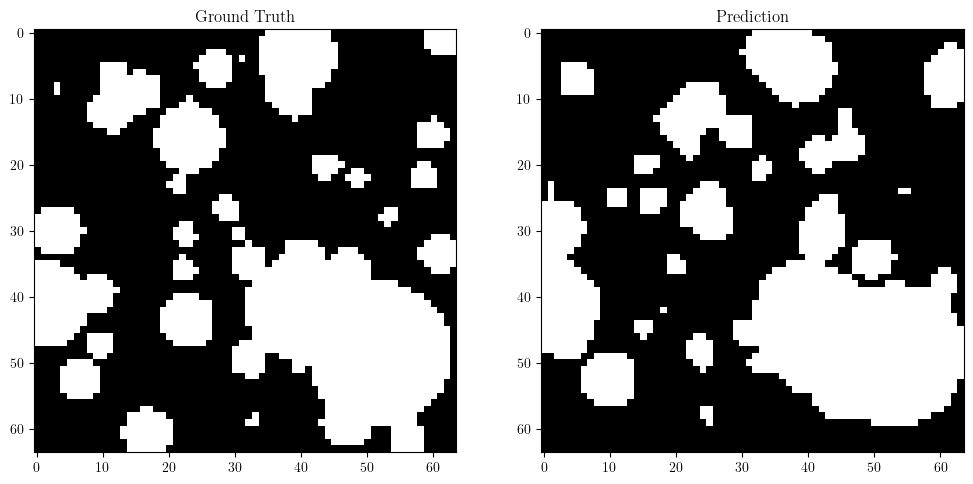

Dice: 0.5923284235895682, Vol frac: 0.24180221557617188, Sigma: 36.62680435180664, Num components: 150


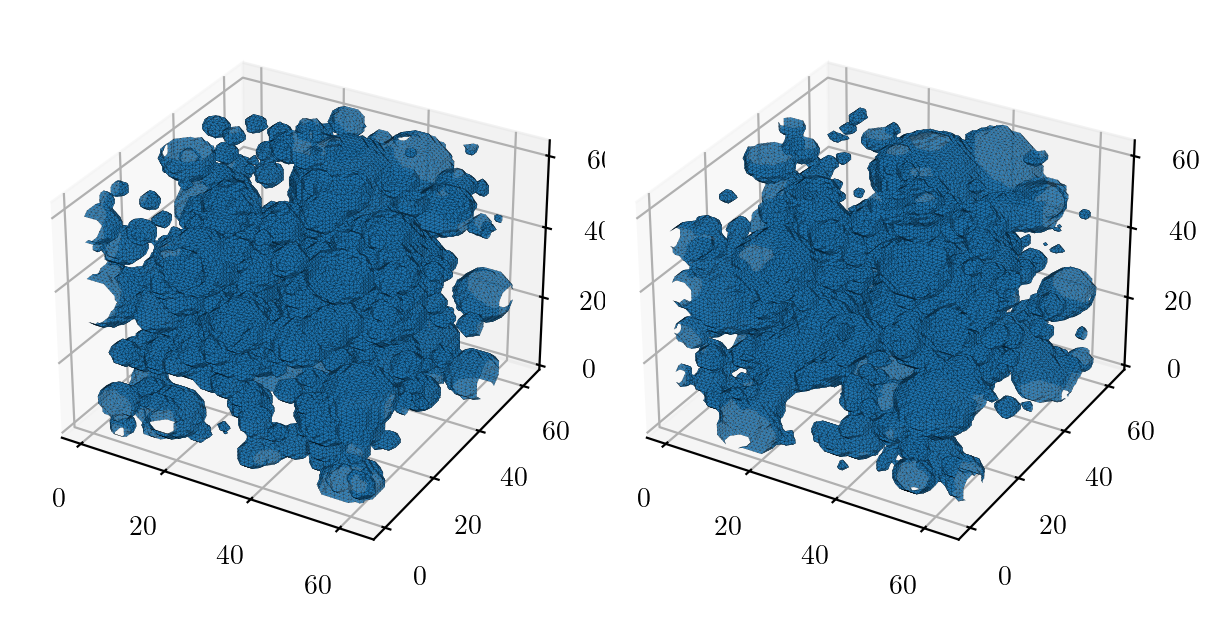

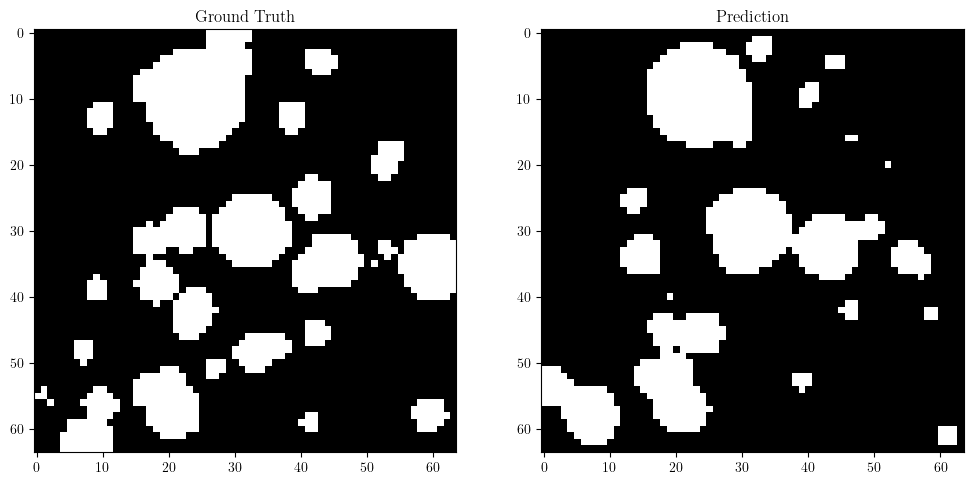

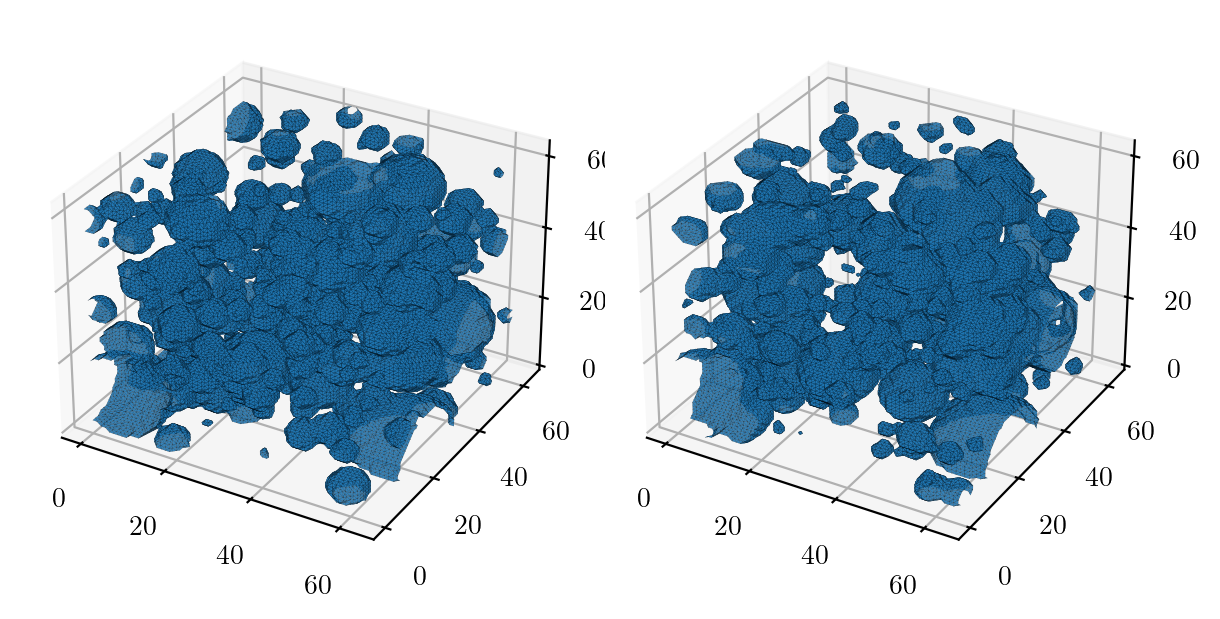

In [20]:
# Visualise a good and bad sample with same volume fraction

visualize_gt_pred(InterfaceType.TANH_EPSILON, 1.0, 1/32, 11)
visualize_gt_pred(InterfaceType.TANH_EPSILON, 1.0, 1/32, 42)

# Summary

 - 

# Next steps

  - 